In [89]:
import matplotlib.pyplot as plt
import numpy as np 
import os
import pandas as pd
import matplotlib.cm as cm
import cv2
import shutil
import seaborn as sns
import random
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Rescaling
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array,load_img
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from IPython.display import Image, display
from tensorflow import keras
from tensorflow.keras.models import Model
import tensorflow as tf

In [ ]:
#Get Data From COVID-19_Radiography_Dataset.zip
#!unzip COVID-19_Radiography_Dataset.zip

In [ ]:
#Remove Masks in Datasets https://pynative.com/python-delete-files-and-directories/#h-delete-a-non-empty-directory-using-shutil
classes = ['COVID','Lung_Opacity','Normal','Viral Pneumonia']
for i in classes:
  shutil.rmtree(f'/content/COVID-19_Radiography_Dataset/{i}/masks')


In [ ]:
#Gather images from Covid 19 dataset using image_dataset_from_directory
train_ds = image_dataset_from_directory(
    directory = '/content/COVID-19_Radiography_Dataset',
    image_size=(256,256),
    batch_size=32,
    seed=42,
    validation_split=0.1,
    shuffle = True,
    subset='training', #train split
    label_mode = 'int'#Default label mode is int, turns the images into a sparse matrix
)
val_ds = image_dataset_from_directory(
    directory = '/content/COVID-19_Radiography_Dataset',
    image_size=(256,256),
    batch_size=32,
    seed=42,
    validation_split=0.1,
    shuffle = True,
    subset='validation', #test split
    label_mode = 'int' 
)

Found 21165 files belonging to 4 classes.
Using 19049 files for training.
Found 21165 files belonging to 4 classes.
Using 2116 files for validation.


In [ ]:
#Showcase the Different types of classes within dataset
train_ds.class_names

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

In [ ]:
#Make image directory
#!mkdir images

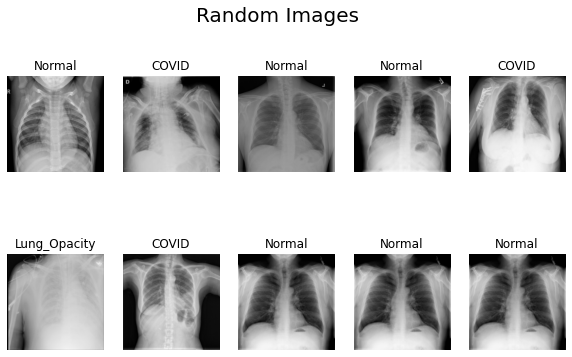

In [ ]:
#How to read in images https://www.tensorflow.org/tutorials/load_data/images
class_names = train_ds.class_names
#Plot 10 random images and labeled them to show what the general data consists of.
plt.figure(figsize=(10, 6))
for images, labels in train_ds.take(1):
  for i in range(10):
    l = random.randint(1,28)
    ax = plt.subplot(2,5, i + 1)
    plt.imshow(images[l].numpy().astype("uint8"))
    plt.title(class_names[labels[l]])
    plt.suptitle('Random Images',size = 20)
    plt.axis('off')
plt.savefig('/content/images/RandomImages.png')


In [ ]:
#Get a count of the amount of images for each class for EDA
class_list = []
count_list =[]
for i in class_names:
  count = 0
  for path in os.listdir(f'/content/COVID-19_Radiography_Dataset/{i}/images'):
    if os.path.isfile(os.path.join(f'/content/COVID-19_Radiography_Dataset/{i}/images',path)):
      count +=1
  class_list.append(i)
  count_list.append(count)


In [ ]:
#Create a DataFrame of classes and count
df = pd.DataFrame(
    {'class': class_list,
     'count': count_list
    })

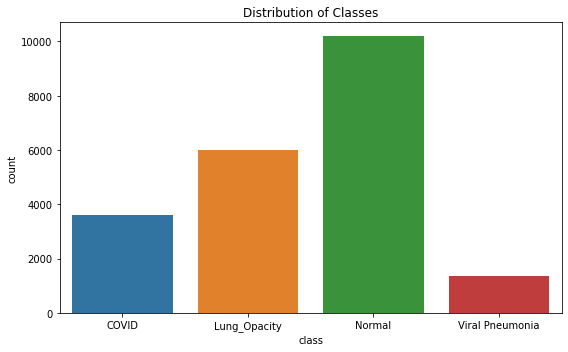

In [ ]:
#Plot the Distribution of Data
plt.figure(figsize = (8,5))
sns.barplot(data=df,x='class',y='count')
plt.title('Distribution of Classes')
plt.tight_layout()
plt.savefig('/content/images/ClassDistribution.png')

With this distribution of classes we can see that we are working with an imbalanced dataset


In [ ]:
# Getting sum of how much files we have so we can get our baseline
sum(df['count'])

21165

In [ ]:
#Baseline 0:Covid   1:Lung_Opacity   2:Normal   3:Viral Pneumonia 
df['count'] / 21165

0    0.170848
1    0.284054
2    0.481550
3    0.063548
Name: count, dtype: float64

From our baseline model we could see that if we just guessed a class on the entire dataset our highest
possibility would be 48%.

# Modelling
Creating a CNN model with 4 convolutional layers, 1 rescaling/dropout/regularizing layer

In [ ]:
es = EarlyStopping(patience = 10)

In [ ]:
#Instantiate the Model and Rescale the shape size of images to be used in
# a convolutional neural network
model = Sequential()
model.add(Rescaling(1./255,input_shape = (256,256,3)))
model.add(Conv2D(16,3,padding='same',activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, padding='same', activation='relu'),)
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding='same', activation='relu'),)
model.add(MaxPooling2D())
model.add(Dropout(0.35))

model.add(Conv2D(64, 3, padding='same', activation='relu'),)
model.add(MaxPooling2D())

#Flatten to convert the 2-Dimensional arrays from pooled feature maps 
#into a single linear vector
model.add(Flatten())
model.add(Dense(128,activation = 'relu',kernel_regularizer = l2(0.001))) #Regularizer to decrease overfitness
model.add(Dense(4,activation='softmax'))

# Had an error of None,1 not matching None,4, image_from_directory returns the output as a sparse matrix
# credits to https://www.kaggle.com/general/197993
model.compile(optimizer ='adam',loss ='sparse_categorical_crossentropy',metrics =['acc'])

In [ ]:
h = model.fit(train_ds,validation_data = val_ds, epochs = 20,batch_size = 64,callbacks = [es])

Epoch 1/20
596/596 [==============================] - 55s 90ms/step - loss: 0.7377 - acc: 0.7381 - val_loss: 0.6056 - val_acc: 0.7850
Epoch 2/20
596/596 [==============================] - 53s 88ms/step - loss: 0.4989 - acc: 0.8427 - val_loss: 0.5532 - val_acc: 0.8143
Epoch 3/20
596/596 [==============================] - 52s 87ms/step - loss: 0.4234 - acc: 0.8693 - val_loss: 0.4381 - val_acc: 0.8587
Epoch 4/20
596/596 [==============================] - 53s 88ms/step - loss: 0.3882 - acc: 0.8831 - val_loss: 0.4368 - val_acc: 0.8639
Epoch 5/20
596/596 [==============================] - 53s 87ms/step - loss: 0.3575 - acc: 0.8966 - val_loss: 0.4203 - val_acc: 0.8748
Epoch 6/20
596/596 [==============================] - 52s 87ms/step - loss: 0.3313 - acc: 0.9046 - val_loss: 0.3934 - val_acc: 0.8842
Epoch 7/20
596/596 [==============================] - 54s 90ms/step - loss: 0.3171 - acc: 0.9122 - val_loss: 0.3655 - val_acc: 0.8937
Epoch 8/20
596/596 [==============================] - 52s 87ms

In [ ]:
#Summary of Parameters being trained within the neural network
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#Lets see the best accuracy score of this model
h.history['acc'][-1], h.history['val_acc'][-1]

(0.9456664323806763, 0.8950850367546082)

## Base Model Plot

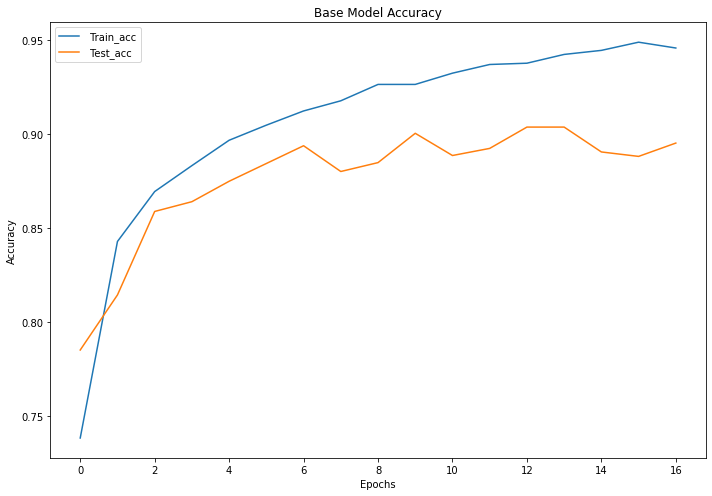

In [ ]:
#Plot how well the model did across its epochs according to accuracy
plt.figure(figsize=(10,7))
plt.plot(h.history['acc'], label = ' Train_acc')
plt.plot(h.history['val_acc'], label = ' Test_acc')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Base Model Accuracy')
plt.tight_layout()
plt.savefig('/content/images/BasemodelAcc.png')

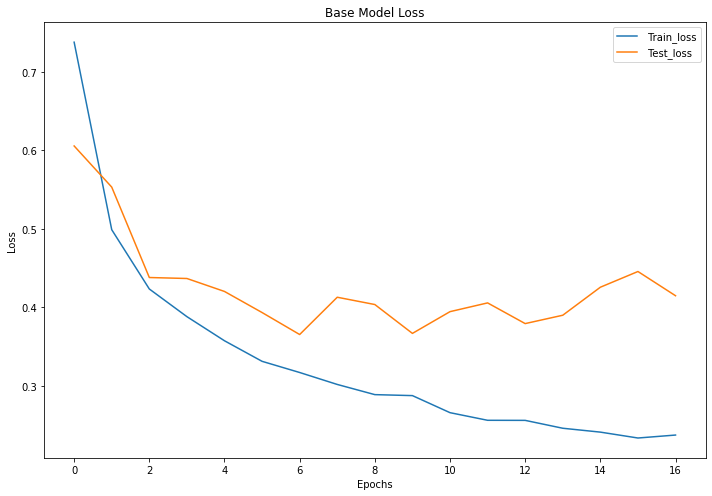

In [ ]:
#Plot the Models loss across the epochs
plt.figure(figsize=(10,7))
plt.plot(h.history['loss'], label = ' Train_loss')
plt.plot(h.history['val_loss'], label = ' Test_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Base Model Loss')
plt.tight_layout()
plt.savefig('/content/images/BaseModelLoss.png')

According to the base model, our data is still overfit

# VGG16 Prebuilt Model
https://keras.io/api/applications/




In [ ]:
# Reread in the Dataset but with image_size being (224,224) VGG16 prebuilt model has
# default image size of (224,224)
train_ds = image_dataset_from_directory(
    directory = '/content/COVID-19_Radiography_Dataset',
    image_size=(224,224),
    batch_size=32,
    seed=42,
    validation_split=0.1,
    shuffle = True,
    subset='training',
    label_mode = 'int'
)
val_ds = image_dataset_from_directory(
    directory = '/content/COVID-19_Radiography_Dataset',
    image_size=(224,224),
    batch_size=32,
    seed=42,
    validation_split=0.1,
    shuffle = True,
    subset='validation',
    label_mode = 'int' 
)

Found 21165 files belonging to 4 classes.
Using 19049 files for training.
Found 21165 files belonging to 4 classes.
Using 2116 files for validation.


In [ ]:
#import vgg16 model
model_builder = keras.applications.VGG16


In [ ]:
# Make the weights for the vgg16 model be imagenet
model = model_builder(weights="imagenet")

553467096/553467096 [==============================] - 26s 0us/step


In [ ]:
model.compile(optimizer ='adam',loss ='sparse_categorical_crossentropy',metrics =['acc'])

In [ ]:
hvgg16 =model.fit(train_ds,validation_data = val_ds,epochs = 10,batch_size = 64)

Epoch 1/10
596/596 [==============================] - 286s 467ms/step - loss: 2.9865 - acc: 0.6538 - val_loss: 0.6504 - val_acc: 0.7443
Epoch 2/10
596/596 [==============================] - 274s 459ms/step - loss: 0.5174 - acc: 0.8007 - val_loss: 0.4381 - val_acc: 0.8341
Epoch 3/10
596/596 [==============================] - 275s 460ms/step - loss: 0.4133 - acc: 0.8442 - val_loss: 0.4391 - val_acc: 0.8228
Epoch 4/10
596/596 [==============================] - 275s 460ms/step - loss: 0.3512 - acc: 0.8676 - val_loss: 0.4622 - val_acc: 0.8289
Epoch 5/10
596/596 [==============================] - 275s 461ms/step - loss: 0.3284 - acc: 0.8761 - val_loss: 0.4137 - val_acc: 0.8535
Epoch 6/10
596/596 [==============================] - 275s 460ms/step - loss: 0.3347 - acc: 0.8804 - val_loss: 0.3302 - val_acc: 0.8804
Epoch 7/10
596/596 [==============================] - 275s 460ms/step - loss: 0.2829 - acc: 0.8962 - val_loss: 0.3267 - val_acc: 0.8814
Epoch 8/10
596/596 [============================

In [ ]:
hvgg16.history['acc'][-1],hvgg16.history['val_acc'][-1], 

(0.90718674659729, 0.8879961967468262)

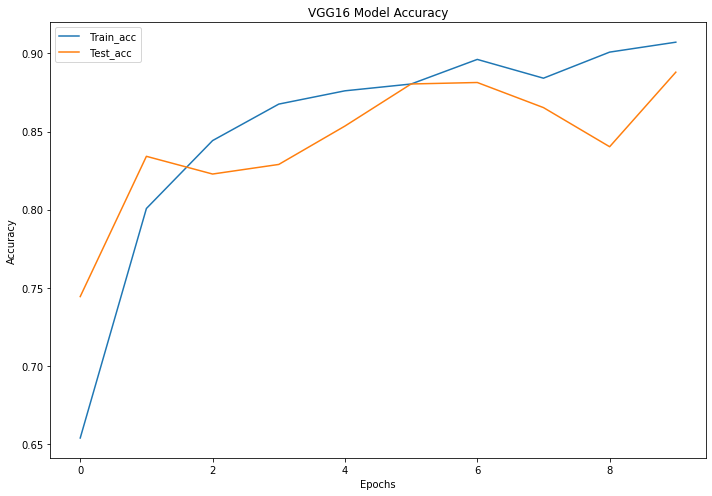

In [ ]:
#Plot how well the model did across its epochs
plt.figure(figsize=(10,7))
plt.plot(hvgg16.history['acc'], label = ' Train_acc')
plt.plot(hvgg16.history['val_acc'], label = ' Test_acc')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('VGG16 Model Accuracy')
plt.tight_layout()
plt.savefig('/content/images/VGG16Acc.png')

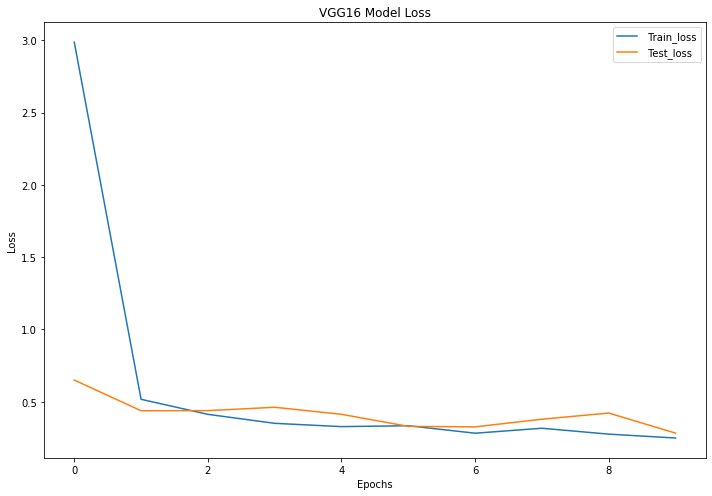

In [ ]:
#Plot the vgg16 models loss
plt.figure(figsize=(10,7))
plt.plot(hvgg16.history['loss'], label = ' Train_loss')
plt.plot(hvgg16.history['val_loss'], label = ' Test_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG16 Model Loss')
plt.tight_layout()
plt.savefig('/content/images/VGG16loss.png')

# VGG16 Gradient Cam
https://keras.io/examples/vision/grad_cam/ 

What is gradient camera and why are we using it? 
Gradient cam is a technique where it creates class activation maps that helps us visualize and interpret how our model looks at our data. Neural networks at baseline are considered to be black-boxes, we don't know whats happening inside to get the result that it spits out, but by taking the gradients of the last convolutional layer and weighing them we can see how on each image our model is classifying them.


In [ ]:
# In order to gradient camera we need the last convolutional layer output from the model

model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#By looking at model.summary() the last convolutional layter is block5_conv3
last_conv_layer_name = "block5_conv3"

In [ ]:
# Functions are taken from keras grad cam tutorial at https://keras.io/examples/vision/grad_cam/
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
#Gathered a random photo from each class to showcase gradient cam
list_img_paths = ['/content/COVID-19_Radiography_Dataset/COVID/images/COVID-1004.png',
                  '/content/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-1002.png',
                  '/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-1008.png',
                  '/content/COVID-19_Radiography_Dataset/Normal/images/Normal-10007.png']

In [ ]:
# Model Requires the preprocessed input and model predictions
# tensorflow has it own function calls on its prebuilt models for this

img_size = (224,224) # Vgg16 default img_size has to be 224,224
preprocess_input = keras.applications.vgg16.preprocess_input
decode_predictions = keras.applications.vgg16.decode_predictions
imag = [] 

In [ ]:
#preprocess every photo within the list_img_paths
processed_images_grad = []
for i in list_img_paths:
  img_array = preprocess_input(get_img_array(i, size=img_size))


  # Remove last layer's softmax
  model.layers[-1].activation = None

  # Print what the top predicted class is
  preds = model.predict(img_array)
  print("Predicted:", decode_predictions(preds, top=1)[0])

  # Generate class activation heatmap
  heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
  processed_images_grad.append(heatmap)

1/1 [==============================] - 0s 22ms/step
Predicted: [('n01440764', 'tench', 8.494431)]
1/1 [==============================] - 0s 17ms/step
Predicted: [('n01443537', 'goldfish', 2.4863424)]
1/1 [==============================] - 0s 19ms/step
Predicted: [('n01443537', 'goldfish', 4.3181734)]
1/1 [==============================] - 0s 16ms/step
Predicted: [('n01443537', 'goldfish', 3.362812)]


In [ ]:
#Function from Keras Tutorial
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


    imag.append(cv2.imread(img_path))
    imag.append(cv2.imread("./cam.jpg"))



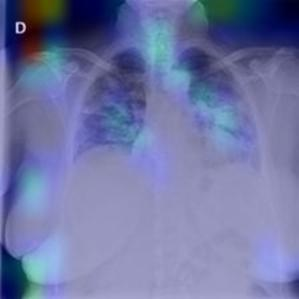

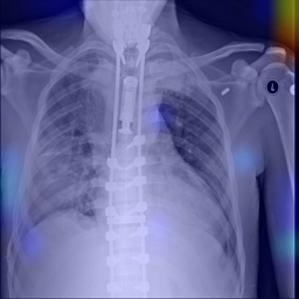

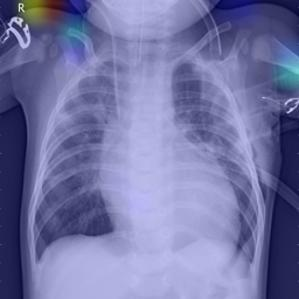

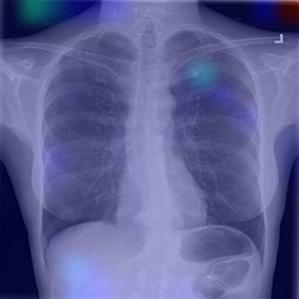

In [ ]:
#save the images into the save gradcam function
for i in range(len(list_img_paths)):
  save_and_display_gradcam(list_img_paths[i], processed_images_grad[i])

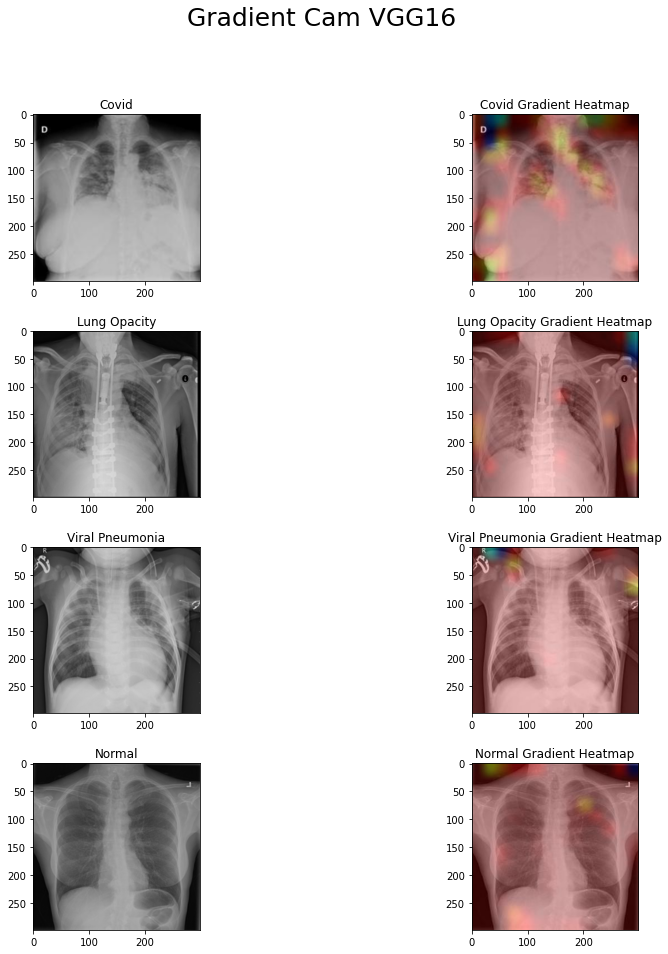

In [ ]:
titles = ['Covid','Covid Gradient Heatmap','Lung Opacity','Lung Opacity Gradient Heatmap','Viral Pneumonia','Viral Pneumonia Gradient Heatmap','Normal','Normal Gradient Heatmap']
# subplot syntax https://www.geeksforgeeks.org/how-to-set-the-spacing-between-subplots-in-matplotlib-in-python/
fig,axs = plt.subplots(4,2, figsize = (15,15),squeeze = False)
fig.suptitle("Gradient Cam VGG16",fontsize = 25)
fig.subplots_adjust(wspace= 0.1,hspace = 0.3)
for i,(img,title) in enumerate(zip(imag,titles)):
      axs[i//2,i%2].imshow(img) 
      axs[i//2,i%2].set_title(title)
plt.savefig('/content/images/GradCamVgg16.png')

# Xception Model


In [ ]:
# Reread in the Dataset but with image_size being (299,299) xception prebuilt model has
# default image size of (299,299)
train_ds = image_dataset_from_directory(
    directory = '/content/COVID-19_Radiography_Dataset',
    image_size=(299,299),
    batch_size=32,
    seed=42,
    validation_split=0.1,
    shuffle = True,
    subset='training',
    label_mode = 'int'
)
val_ds = image_dataset_from_directory(
    directory = '/content/COVID-19_Radiography_Dataset',
    image_size=(299,299),
    batch_size=32,
    seed=42,
    validation_split=0.1,
    shuffle = True,
    subset='validation',
    label_mode = 'int' 
)

Found 21165 files belonging to 4 classes.
Using 19049 files for training.
Found 21165 files belonging to 4 classes.
Using 2116 files for validation.


In [ ]:
#Instantiate the model to be xception
model_builder = keras.applications.xception.Xception
model = model_builder(weights="imagenet")


91884032/91884032 [==============================] - 5s 0us/step


In [ ]:
es = EarlyStopping(patience = 3)

In [ ]:
#Compile Model
model.compile(optimizer ='adam',loss ='sparse_categorical_crossentropy',metrics =['acc'])

In [85]:
#fit model
hxception =model.fit(train_ds,validation_data = val_ds,epochs = 10,batch_size = 64,callbacks = [es])

Epoch 1/10
596/596 [==============================] - 725s 1s/step - loss: 0.2911 - acc: 0.9072 - val_loss: 0.2105 - val_acc: 0.9249
Epoch 2/10
596/596 [==============================] - 721s 1s/step - loss: 0.1528 - acc: 0.9473 - val_loss: 0.4101 - val_acc: 0.8629
Epoch 3/10
596/596 [==============================] - 721s 1s/step - loss: 0.1219 - acc: 0.9568 - val_loss: 0.2442 - val_acc: 0.9149
Epoch 4/10
596/596 [==============================] - 722s 1s/step - loss: 0.1024 - acc: 0.9636 - val_loss: 0.2249 - val_acc: 0.9130


In [86]:
#Quick Glance at what our accuracys are
hxception.history['acc'][-1], hxception.history['val_acc'][-1]

(0.9635676145553589, 0.9130434989929199)

# Xception Plot

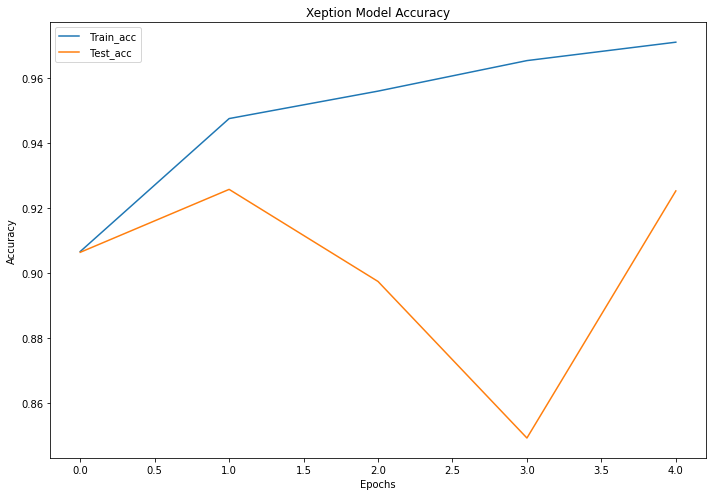

In [ ]:
#Plot the Xception accuracy to see how the model performed across the epochs
plt.figure(figsize=(10,7))
plt.plot(hxception.history['acc'], label = ' Train_acc')
plt.plot(hxception.history['val_acc'], label = ' Test_acc')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Xeption Model Accuracy')
plt.tight_layout()
plt.savefig('/content/images/XceptionAcc.png')

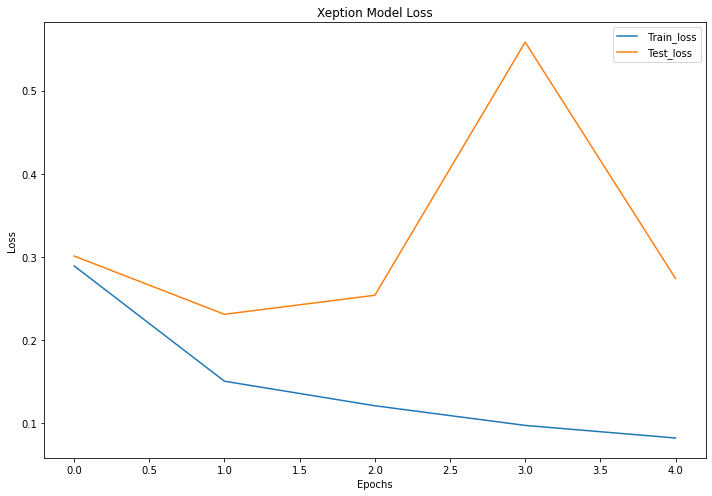

In [ ]:
#Plot the Xception accuracy to see how the model performed across the epochs

plt.figure(figsize=(10,7))
plt.plot(hxception.history['loss'], label = ' Train_loss')
plt.plot(hxception.history['val_loss'], label = ' Test_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Xeption Model Loss')
plt.tight_layout()
plt.savefig('/content/images/XceptionLoss.png')

# Xception Grad Model

In [ ]:
# revariable the preprocessinput and decode predictions for our grad cam functions
img_size = (299,299) # xCeption default img_size has to be 299,299
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions
imag = [] #empty the imag list so all the images are from the xception model only

In [ ]:
#The last Convolutional layer of xception is block14_sepconv2_act
last_conv_layer_name = "block14_sepconv2_act"

In [ ]:
processed_images_grad = []
for i in list_img_paths:
  img_array = preprocess_input(get_img_array(i, size=img_size))


  # Remove last layer's softmax
  model.layers[-1].activation = None

  # Print what the top predicted class is
  preds = model.predict(img_array)
  print("Predicted:", decode_predictions(preds, top=1)[0])

  # Generate class activation heatmap
  heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
  processed_images_grad.append(heatmap)

1/1 [==============================] - 1s 823ms/step
Predicted: [('n03388043', 'fountain', 7.473603)]
1/1 [==============================] - 0s 18ms/step
Predicted: [('n03868863', 'oxygen_mask', 5.3200374)]
1/1 [==============================] - 0s 19ms/step
Predicted: [('n03868863', 'oxygen_mask', 5.548245)]
1/1 [==============================] - 0s 20ms/step
Predicted: [('n01910747', 'jellyfish', 5.034982)]


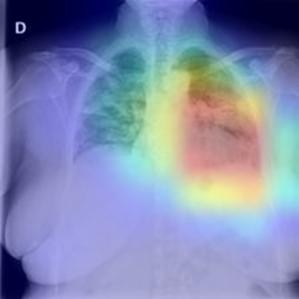

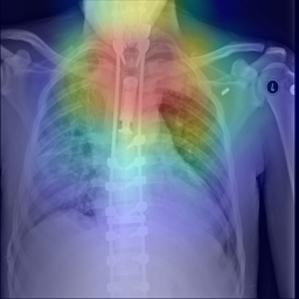

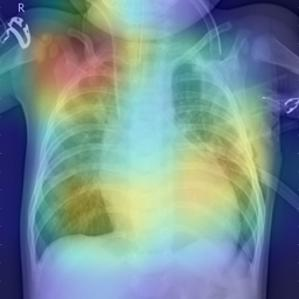

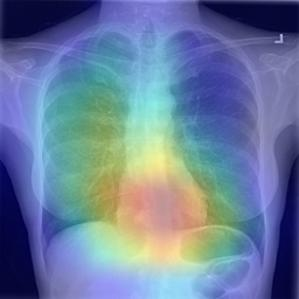

In [ ]:
#use the save and display function to append the images into a list
for i in range(len(list_img_paths)):
  save_and_display_gradcam(list_img_paths[i], processed_images_grad[i])

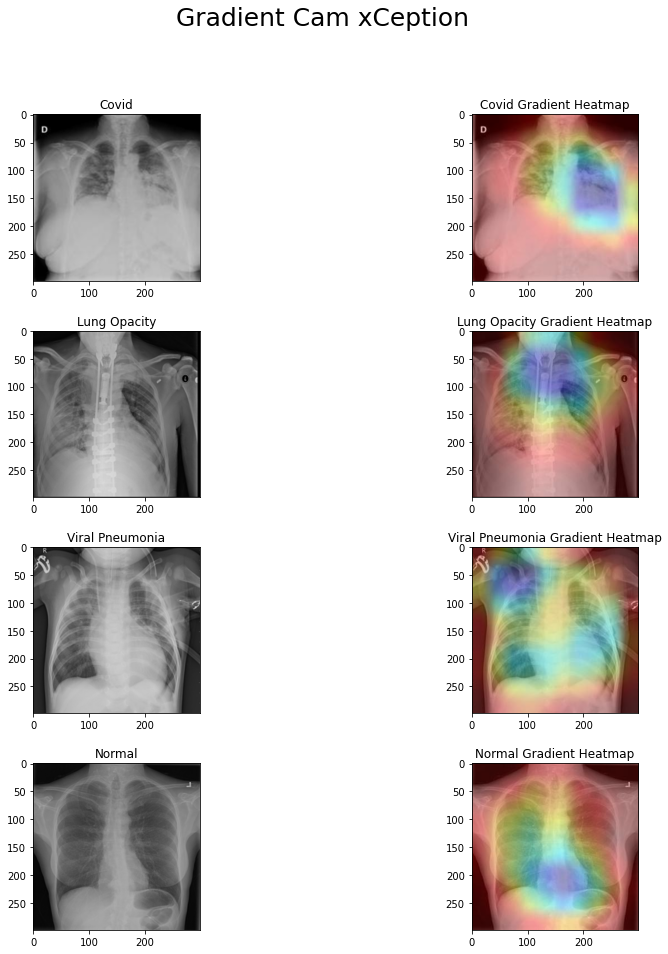

In [ ]:
titles = ['Covid','Covid Gradient Heatmap','Lung Opacity','Lung Opacity Gradient Heatmap','Viral Pneumonia','Viral Pneumonia Gradient Heatmap','Normal','Normal Gradient Heatmap']
# subplot syntax https://www.geeksforgeeks.org/how-to-set-the-spacing-between-subplots-in-matplotlib-in-python/
fig,axs = plt.subplots(4,2, figsize = (15,15),squeeze = False)
fig.suptitle("Gradient Cam xCeption",fontsize = 25)
fig.subplots_adjust(wspace= 0.1,hspace = 0.3)
for i,(img,title) in enumerate(zip(imag,titles)):
      axs[i//2,i%2].imshow(img)
      axs[i//2,i%2].set_title(title)
plt.savefig('/content/images/GradCamXception.png')      

# Model Evaluation


## Confusion Matrix


In [88]:
# How to get image batches from imagedatasetfromdirectory https://stackoverflow.com/questions/64687375/get-labels-from-dataset-when-using-tensorflow-image-dataset-from-directory

pred_list = []  # store predicted labels
true_list = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in val_ds: 
   # append true labels
   true_list.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   pred_list.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_classes = tf.concat([item for item in true_list], axis = 0)
predicted_classes = tf.concat([item for item in pred_list], axis = 0)

1/1 [==============================] - 1s 642ms/step


In [90]:
#Create the confusion matrix from sklearns confusion matrix
cm = confusion_matrix(correct_classes,predicted_classes)

In [91]:
cm

array([[317,   4,  25,  11],
       [  3, 501, 110,   0],
       [  0,  11, 978,   2],
       [  0,   0,  18, 136]])

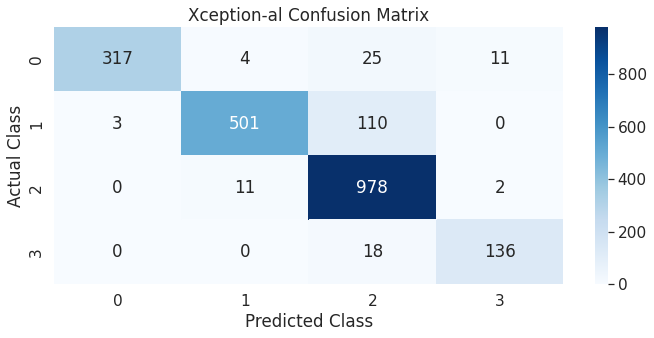

In [97]:
#Plot the confusionmatrix with seaborns heatmap to see how the model performed
plt.figure(figsize = (10,5))
sns.heatmap(cm,annot = True, cmap = 'Blues',fmt = 'g') #fmt = g makes it so the values are not in scientfic notation
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Xception-al Confusion Matrix')
plt.tight_layout()
plt.savefig('/content/images/ConfusionMatrix.png')

In [96]:
# SkLearns classificaiton report to see the models evaluation meterics
# 0:Covid   1:Lung_Opacity   2:Normal   3:Viral Pneumonia 

print(classification_report(correct_classes,predicted_classes))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94       357
           1       0.97      0.82      0.89       614
           2       0.86      0.99      0.92       991
           3       0.91      0.88      0.90       154

    accuracy                           0.91      2116
   macro avg       0.93      0.89      0.91      2116
weighted avg       0.92      0.91      0.91      2116



With the above confusion matrix and classfication report we can see that we're getting the majority of our misclassifications in the normal images. This makes sense as a normal would be the most vague class to classify, as covid and pneumonia youre looking for a certain object within the images.